# **Final XGBoost work**

## 1) Loading Data and Packages + Util

In [17]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

Load data from local folder

In [2]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving all_fitbit_data_daily_w_visit.csv to all_fitbit_data_daily_w_visit.csv
Saving data_daily_w_visits.csv to data_daily_w_visits.csv
Saving adh.csv to adh.csv


Setup fitbit_data

In [3]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')

In [4]:
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')

In [5]:
adh_data = pd.read_csv('/content/data/adh.csv')

In [6]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']

In [7]:
def compute_metrics(y_true, y_prob, thresh: float = 0.5):
    y_pred = (y_prob > thresh).astype(int)
    auroc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true,y_pred)
    cm = confusion_matrix(y_true,y_pred)

    return acc, auroc, auprc, cm

## 2) Analyzing + Transforming Data

Preliminary setup

In [8]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)

In [ ]:
fitbit_data_w_visits = fitbit_data[fitbit_data['visit_day'] == 1].reset_index(drop=True)
fitbit_data_w_visits

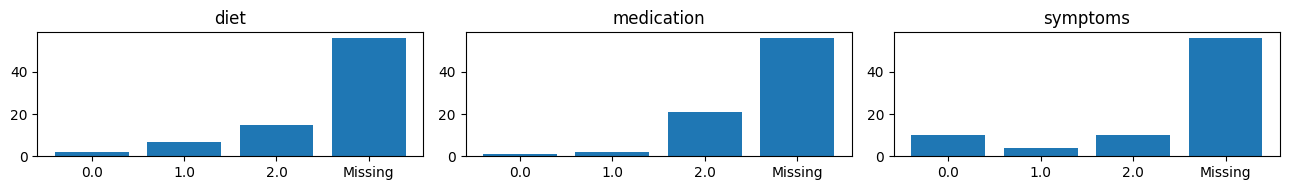

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(13, 2))

for ax, col in zip(axs, ['diet', 'medication', 'symptoms']):
    # Replace NaNs with a placeholder
    values = fitbit_data_w_visits[col].fillna('Missing').astype(str)

    # Get value counts
    counts = values.value_counts().sort_index()

    # Bar plot
    ax.bar(counts.index, counts.values)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [11]:
pre_visit_data = []

for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    group = group.sort_values('days').reset_index(drop=True)

    visit_indices = group.index[group['visit_day'] == 1].tolist()

    for vi in visit_indices:
        start = max(vi - 14, 0)
        end = vi + 1  # include the visit day
        temp = group.iloc[start:end].copy()
        temp['days_to_visit'] = temp['days'] - temp['days'].iloc[-1]
        temp['fitbit_user_id'] = user_id
        pre_visit_data.append(temp)

# Combine all extracted windows
pre_visit_df = pd.concat(pre_visit_data, ignore_index=True)

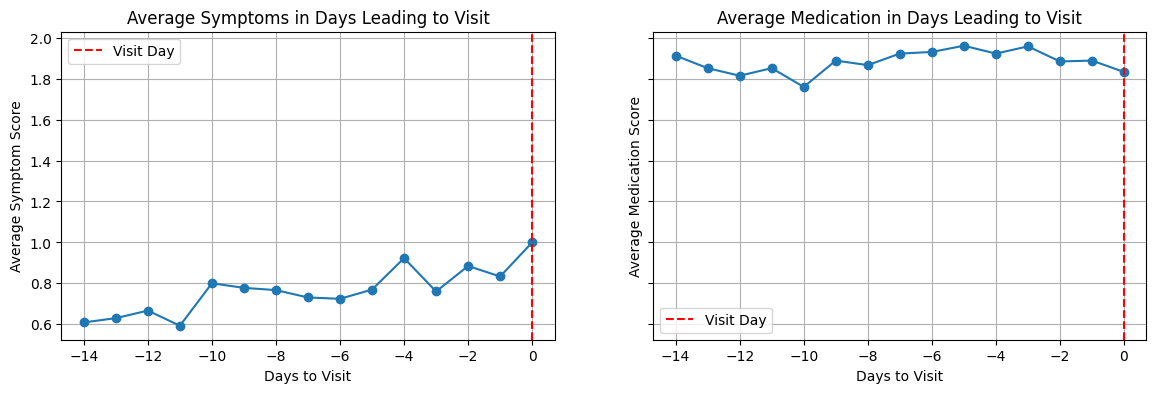

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey = True)

avg_symptoms = pre_visit_df.groupby('days_to_visit')['symptoms'].mean()
axs[0].plot(avg_symptoms.index, avg_symptoms.values, marker='o')
axs[0].set_title("Average Symptoms in Days Leading to Visit")
axs[0].set_xlabel("Days to Visit")
axs[0].set_ylabel("Average Symptom Score")
axs[0].grid(True)
axs[0].axvline(0, color='red', linestyle='--', label='Visit Day')
axs[0].legend()

avg_medication = pre_visit_df.groupby('days_to_visit')['medication'].mean()
axs[1].plot(avg_medication.index, avg_medication.values, marker='o')
axs[1].set_title("Average Medication in Days Leading to Visit")
axs[1].set_xlabel("Days to Visit")
axs[1].set_ylabel("Average Medication Score")
axs[1].grid(True)
axs[1].axvline(0, color='red', linestyle='--', label='Visit Day')
axs[1].legend()

plt.show()

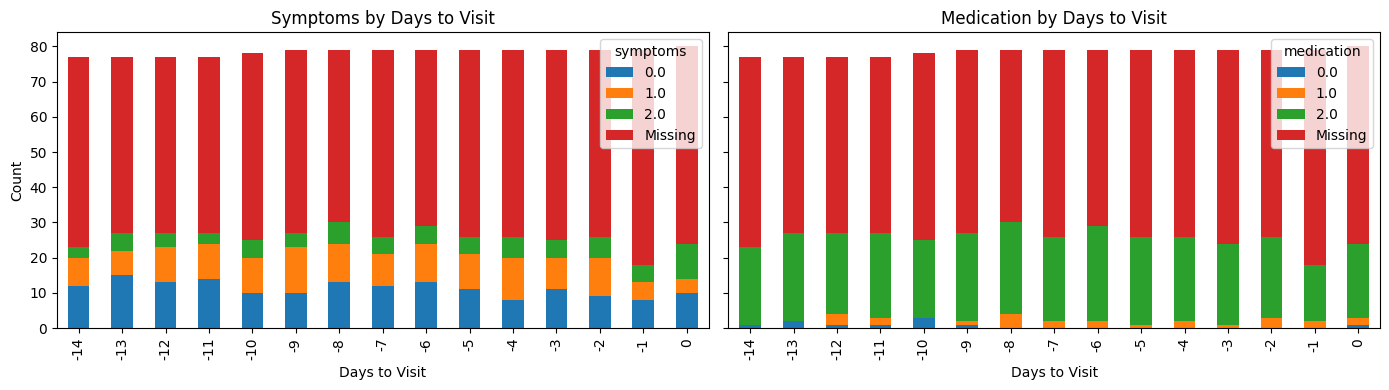

In [13]:
# Replace NaNs with a string label
pre_visit_df['symptoms'] = pre_visit_df['symptoms'].fillna('Missing').astype(str)
pre_visit_df['medication'] = pre_visit_df['medication'].fillna('Missing').astype(str)

# Group and unstack to prepare for stacked bar plotting
symptoms_ct = pre_visit_df.groupby(['days_to_visit', 'symptoms']).size().unstack(fill_value=0)
medication_ct = pre_visit_df.groupby(['days_to_visit', 'medication']).size().unstack(fill_value=0)

# Plot stacked bars
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Symptoms
symptoms_ct.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title("Symptoms by Days to Visit")
axs[0].set_xlabel("Days to Visit")
axs[0].set_ylabel("Count")

# Medication
medication_ct.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title("Medication by Days to Visit")
axs[1].set_xlabel("Days to Visit")

plt.tight_layout()
plt.show()


One hot encode

In [14]:
# One hot encode
fitbit_data = pd.get_dummies(
    fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

all_fitbit_data = pd.get_dummies(
    all_fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

In [ ]:
(all_fitbit_data.isna().sum() / len(all_fitbit_data)).sort_values(ascending=False)

In [ ]:
fitbit_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,270.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,141.0,23.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,172.0,53.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,99.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,2244.0,64.0,3297.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44816,44816,2025-03-13,No App,307,NaN,2152.0,63.0,3730.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44817,44817,2025-03-14,No App,307,NaN,2529.0,64.0,6657.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44818,44818,2025-03-15,No App,307,NaN,2494.0,64.0,7626.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
fitbit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44820 entries, 0 to 44819
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               44820 non-null  int64         
 1   date                     44820 non-null  datetime64[ns]
 2   study_group              44820 non-null  object        
 3   fitbit_user_id           44820 non-null  int64         
 4   avgWeight_per_day        32886 non-null  float64       
 5   calories                 41396 non-null  float64       
 6   heart                    34401 non-null  float64       
 7   steps                    41358 non-null  float64       
 8   minutes_asleep           30702 non-null  float64       
 9   minutes_awake            30702 non-null  float64       
 10  days                     44820 non-null  int64         
 11  admit_type               73 non-null     object        
 12  death                    80 non-

In [ ]:
fitbit_data.describe()

,Unnamed: 0,date,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,days,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
count,44820.000000,44820,44820.000000,32886.000000,41396.000000,34401.000000,41358.000000,30702.000000,30702.000000,44820.000000,...,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000
mean,22409.500000,2023-03-04 14:47:42.650602240,152.518072,189.784778,2235.929534,65.401733,5234.779148,383.079734,54.538662,89.500000,...,0.360018,0.471307,0.004462,0.019835,0.504507,0.471196,0.357854,0.156917,0.014123,0.471107
min,0.000000,2021-07-26 00:00:00,1.000000,33.951148,267.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11204.750000,2022-05-26 00:00:00,80.000000,160.275874,1786.000000,60.000000,2201.000000,317.250000,36.000000,44.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22409.500000,2023-02-16 00:00:00,152.000000,183.644846,2151.500000,64.000000,4441.000000,391.000000,53.000000,89.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33614.250000,2023-11-08 00:00:00,222.000000,211.643520,2557.000000,72.000000,7291.000000,457.000000,70.000000,134.250000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,44819.000000,2025-03-16 00:00:00,307.000000,398.705527,13442.000000,118.000000,37020.000000,1545.000000,435.000000,179.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,12938.563869,NaN,86.485919,45.383202,767.532572,9.289836,4163.937032,126.255121,29.144155,51.961302,...,0.480011,0.499182,0.066652,0.139434,0.499985,0.499175,0.479374,0.363726,0.118000,0.499170


In [ ]:
fitbit_data[target_col]

,visit_day
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
44815,0.0
44816,0.0
44817,0.0
44818,0.0


In [ ]:
fitbit_data[measure_features + one_h_feaatures + [target_col]].corr()

,avgWeight_per_day,calories,heart,steps,diet_response_0.0,diet_response_1.0,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan,visit_day
avgWeight_per_day,1.000000,0.373354,0.129531,-0.144976,-0.012775,0.115264,0.037072,-0.116215,0.026173,0.037068,0.100517,-0.116188,0.037277,0.057270,0.128357,-0.115703,-0.000209
calories,0.373354,1.000000,-0.023124,0.456305,-0.022520,0.036252,-0.007507,-0.009382,-0.001204,0.008699,0.006654,-0.009054,0.047490,-0.054580,0.015333,-0.009188,-0.015476
heart,0.129531,-0.023124,1.000000,-0.173048,-0.033483,0.015795,0.039888,-0.037826,0.033239,0.069086,0.012165,-0.038015,-0.024675,0.060177,0.062618,-0.037960,0.014878
steps,-0.144976,0.456305,-0.173048,1.000000,-0.014462,0.004755,0.038059,-0.035000,-0.014207,-0.012302,0.040083,-0.034741,0.138243,-0.112696,-0.063136,-0.035018,-0.030752
diet_response_0.0,-0.012775,-0.022520,-0.033483,-0.014462,1.000000,-0.075231,-0.143982,-0.181251,0.055853,0.091097,0.148067,-0.181211,0.072133,0.143803,0.028087,-0.180695,-0.002408
diet_response_1.0,0.115264,0.036252,0.015795,0.004755,-0.075231,1.000000,-0.293930,-0.370012,0.027959,0.118060,0.331891,-0.369140,0.259858,0.162634,0.005971,-0.369469,-0.005680
diet_response_2.0,0.037072,-0.007507,0.039888,0.038059,-0.143982,-0.293930,1.000000,-0.708156,0.024406,0.020650,0.697280,-0.707438,0.519989,0.252394,0.102067,-0.707405,-0.015198
diet_response_nan,-0.116215,-0.009382,-0.037826,-0.035000,-0.181251,-0.370012,-0.708156,1.000000,-0.063212,-0.133992,-0.951290,0.998702,-0.703621,-0.406719,-0.112628,0.998702,0.019373
medication_response_0.0,0.026173,-0.001204,0.033239,-0.014207,0.055853,0.027959,0.024406,-0.063212,1.000000,-0.009524,-0.067556,-0.063198,0.010076,0.053948,0.060072,-0.063187,0.005099
medication_response_1.0,0.037068,0.008699,0.069086,-0.012302,0.091097,0.118060,0.020650,-0.133992,-0.009524,1.000000,-0.143542,-0.134282,0.040013,0.120324,0.034505,-0.134258,0.001566


Missingness in columns

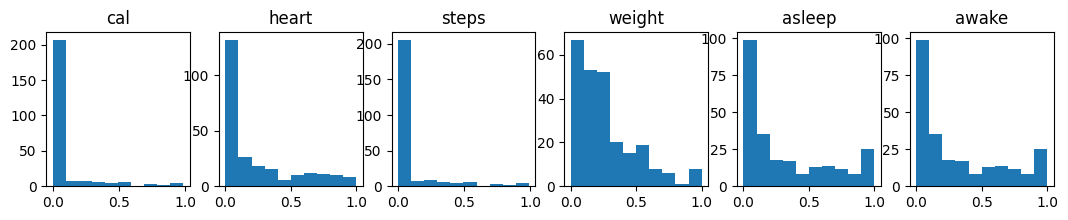

In [ ]:
cal = []
heart = []
steps = []
weight = []
asleep = []
awake = []
for i in all_fitbit_data['fitbit_user_id'].unique():
    temp = all_fitbit_data[all_fitbit_data['fitbit_user_id']==i].reset_index(drop=True)
    cal += [temp['calories'].isna().sum()/len(temp)]
    heart += [temp['heart'].isna().sum()/len(temp)]
    steps += [temp['steps'].isna().sum()/len(temp)]
    weight += [temp['avgWeight_per_day'].isna().sum()/len(temp)]
    asleep += [temp['minutes_asleep'].isna().sum()/len(temp)]
    awake += [temp['minutes_awake'].isna().sum()/len(temp)]

fig, axs = plt.subplots(1,6,figsize=(13,2))
axs[0].hist(cal)
axs[0].set_title('cal')
axs[1].hist(heart)
axs[1].set_title('heart')
axs[2].hist(steps)
axs[2].set_title('steps')
axs[3].hist(weight)
axs[3].set_title('weight')
axs[4].hist(asleep)
axs[4].set_title('asleep')
axs[5].hist(awake)
axs[5].set_title('awake')
plt.show()

*   weight, sleep numbers are missing alot

## 3) Setting Visit Col + Imputation + Standardize

In [16]:
def mark_two_weeks_before_visits(df):
    df = df.copy()

    for user_id, group in df.groupby('fitbit_user_id'):
        visit_days = group.loc[group['visit_day'] == 1, 'days'].values

        for vd in visit_days:
            mask = (df['fitbit_user_id'] == user_id) & (df['days'] >= vd - 14) & (df['days'] <= vd)
            df.loc[mask, 'visit_day'] = 1

    return df

def mark_up_to_final_visit(df):
    df = df.copy()

    for user_id, group in df.groupby('fitbit_user_id'):
        user_mask = df['fitbit_user_id'] == user_id
        visit_days = group.loc[group['visit_day'] == 1, 'days']

        if not visit_days.empty:
            last_visit_day = visit_days.max()
            mask = user_mask & (df['days'] <= last_visit_day)
            df.loc[mask, 'visit_day'] = 1

    return df

In [15]:
def fix_nans(df, features, max_nans=3, window_days=7):
    df = df.copy()
    cleaned_data = []

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy().reset_index(drop=True)
        feature_values = {feature: [] for feature in features}

        for i in range(0, len(group), window_days):
            window = group.iloc[i:i+window_days].copy()
            drop_window = False

            for feature in features:
                nan_count = window[feature].isna().sum()
                if nan_count >= max_nans:
                    drop_window = True

                for j in range(len(window)):
                    val = window.iloc[j][feature]
                    if pd.notna(val):
                        feature_values[feature].append(val)
                    else:
                        if len(feature_values[feature]) == 0:
                            drop_window = True
                        else:
                            mean_val = float(np.mean(feature_values[feature]))
                            feature_values[feature].append(mean_val)
                            window.loc[window.index[j], feature] = mean_val

            if not drop_window:
                cleaned_data.append(window)

    result_df = pd.concat(cleaned_data, ignore_index=True)
    return result_df

In [18]:
week_level = mark_two_weeks_before_visits(fitbit_data)
user_level = mark_up_to_final_visit(fitbit_data)

week_level = fix_nans(week_level, measure_features)
user_level = fix_nans(user_level, measure_features)

scaler = StandardScaler()

week_scaled = week_level.copy()
week_scaled[measure_features] = scaler.fit_transform(week_scaled[measure_features])

user_scaled = user_level.copy()
user_scaled[measure_features] = scaler.fit_transform(user_scaled[measure_features])

In [20]:
week_scaled.to_csv('week_level.csv', index=False)
user_scaled.to_csv('user_level.csv', index=False)

files.download("week_level.csv")
files.download("user_level.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>